# Segmenting and Clustering Neighbourhoods in Toronto

Install and import require packages.

In [144]:
#! pip install pandas
#! pip install numpy
#! pip install requests
#! pip install beautifulsoup4
#! pip install geocoder
#! pip install folium
#!pip install sklearn

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geocoder
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

# Part 1

## Request & Prepare data

Retrieve the post code information from Wikipedia and parse using BeautifulSoup

In [77]:
wikipedia_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
postcodes = requests.get(wikipedia_url)
postcode_soup = BeautifulSoup(postcodes.content, 'html.parser')
tables = postcode_soup.find_all('table')
postcode_table = tables[0]
table_body = postcode_table.find('tbody')
cells = table_body.find_all('td')

Iterating through table cells
- First 3 letters are the postcode
- Assumes only 1 Borough per postcode and the name of the Borough is after the postcode and before the first parentheses.
- Assumes the string of characters between the first set of parentheses are the neighbourhoods in the borough. 
- MJ4 and M3K do not fit this pattern.

In [78]:
district_neighbourhoods = []
for cell in cells:
    _text = cell.text.strip()
    if 'not assigned' in _text.lower(): 
        continue
        
    district_neighbourhoods.append({
        'Postcode': _text[0:3],
        'Borough': _text[3:_text.index('(')],
        'Neighbourhood': (_text[_text.index('(')+1:_text.index(')')]).replace(' / ', ', ')})

df_districts = pd.DataFrame(district_neighbourhoods)

update_neighbourhoods = {
    'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
    'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
    'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
    'MississaugaCanada Post Gateway Processing Centre':'Mississauga'}

df_districts['Borough'] = df_districts['Borough'].replace(update_neighbourhoods)
df_districts.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [79]:
print(df_districts.shape)

(103, 3)


# Part 2

## Obtain latitude and longitude for Borough's in Toronto

In [80]:
latlng = [(geocoder.arcgis(f'{i}, Toronto, Ontario')).latlng for i in df_districts['Postcode']]
df_districts['Latitude'] = [i[0] for i in latlng]
df_districts['Longitude'] = [i[1] for i in latlng]
df_districts.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188


# Part 3

## Explore and cluster neighbourhoods in Toronto

In [81]:
# Foursquare details
CLIENT_ID = '' 
CLIENT_SECRET = '' 
VERSION = '20180605'
LIMIT = 100

#### Find the Borough's with the most neighbourhoods

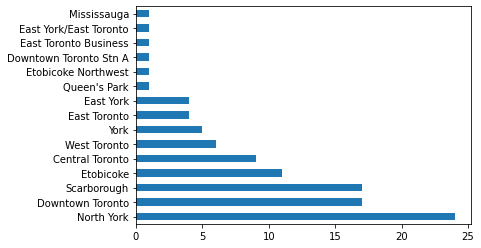

In [82]:
df_districts['Borough'].value_counts().plot(kind='barh');

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighbourhood', 
        'Neighbourhood Latitude', 
        'Neighbourhood Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category']

    return(nearby_venues)

North York has the largest number of neighbourhoods. Use the getNearbyVenues() function to retrieve the venues for this Borough.

In [84]:
north_york_data = df_districts[df_districts['Borough'] == 'North York'].reset_index(drop=True)
north_york_data = getNearbyVenues(
    names=north_york_data['Neighbourhood'],
    latitudes=north_york_data['Latitude'],
    longitudes=north_york_data['Longitude'])
north_york_data.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75245,-79.32991,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park
4,Victoria Village,43.73057,-79.31306,Memories of Africa,43.726602,-79.312427,Grocery Store


#### How many venues in each Neighbourhood?

<AxesSubplot:ylabel='Neighbourhood'>

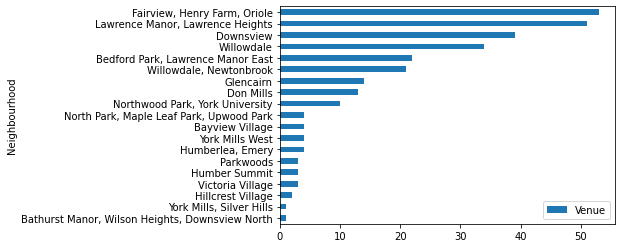

In [85]:
df_venue_counts = north_york_data.groupby('Neighbourhood').count()
df_venue_counts.reset_index(inplace=True)
df_venue_counts = df_venue_counts[['Neighbourhood', 'Venue']]
df_venue_counts.sort_values(by='Venue').plot.barh(x='Neighbourhood', y='Venue')

In [86]:
print('There are {} uniques categories in North York.'.format(len(north_york_data['Venue Category'].unique())))

There are 105 uniques categories in North York.


#### Create One Hot encoding for all venues in North York's Neighbourhoods.

In [87]:
# one hot encoding
north_york_onehot = pd.get_dummies(north_york_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
north_york_onehot['Neighbourhood'] = north_york_data['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [north_york_onehot.columns[-1]] + list(north_york_onehot.columns[:-1])
north_york_onehot = north_york_onehot[fixed_columns]

north_york_onehot.head()

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,...,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Women's Store
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
north_york_onehot.shape

(286, 106)

In [89]:
north_york_grouped = north_york_onehot.groupby('Neighbourhood').mean().reset_index()
north_york_grouped

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,...,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Women's Store
0,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,Bayview Village,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.50,0.000000,0.000000,0.000000,0.000000
2,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.045455,0.000000,0.045455,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3,Don Mills,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
4,Downsview,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025641,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.051282,0.000000,0.076923,0.000000
5,"Fairview, Henry Farm, Oriole",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.037736,0.018868,...,0.000000,0.018868,0.000000,0.018868,0.037736,0.00,0.000000,0.018868,0.000000,0.037736
6,Glencairn,0.000000,0.000000,0.071429,0.0,0.000000,0.000000,0.071429,0.071429,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
7,Hillcrest Village,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
8,Humber Summit,0.000000,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
9,"Humberlea, Emery",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000


#### Visulaise the frequency of venues for each Neighbourhood

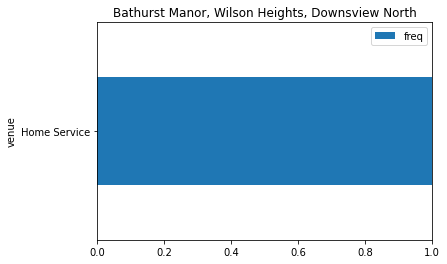

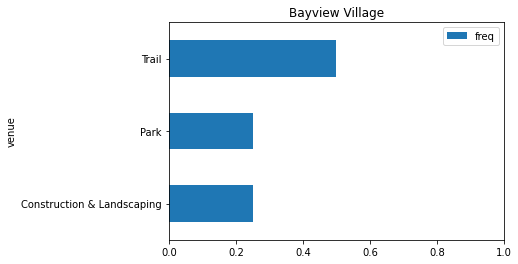

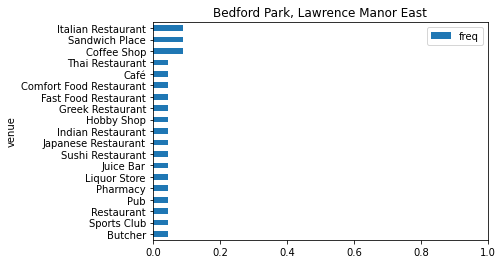

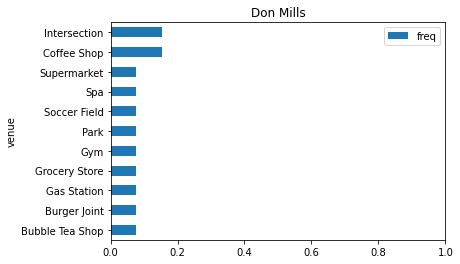

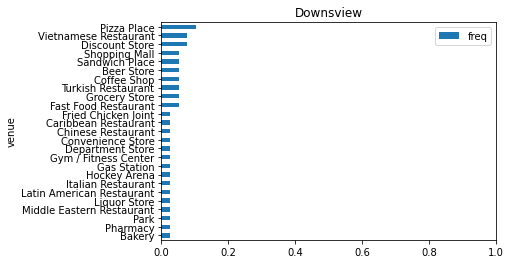

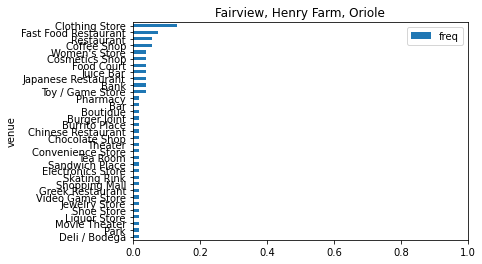

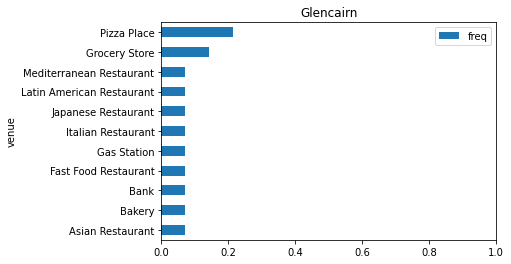

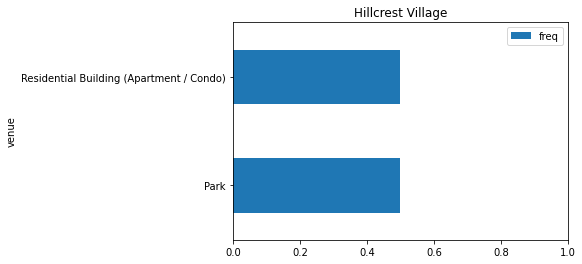

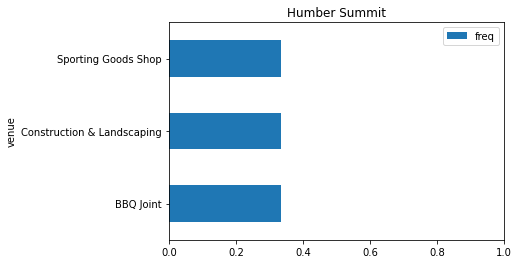

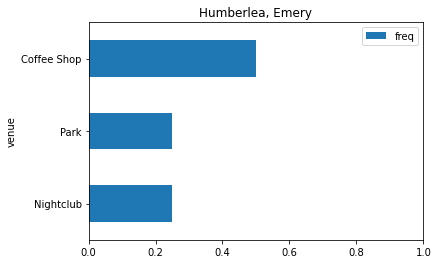

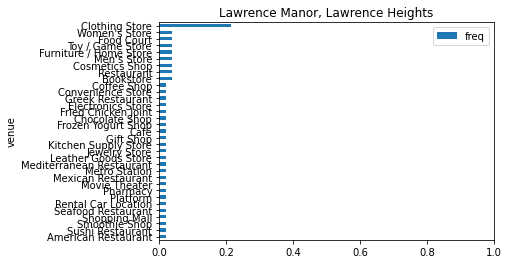

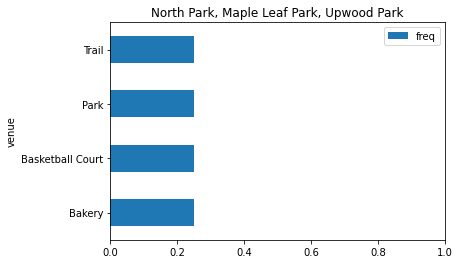

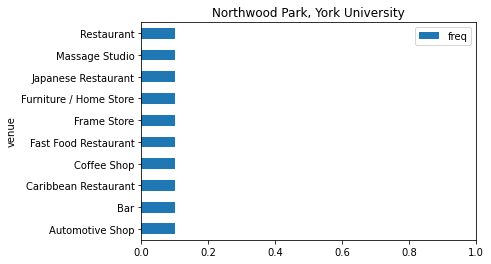

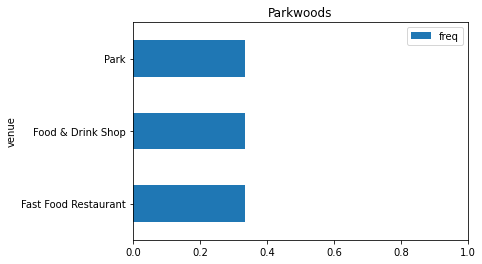

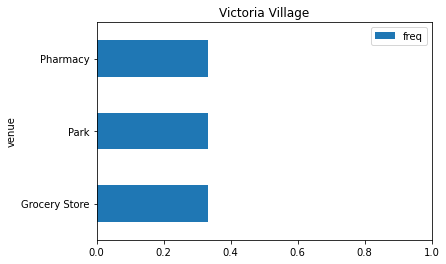

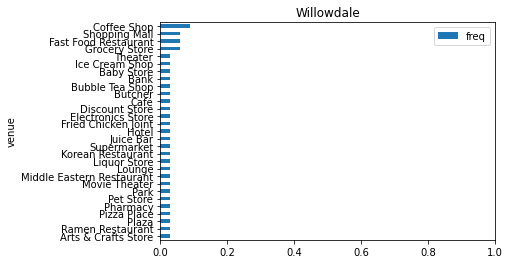

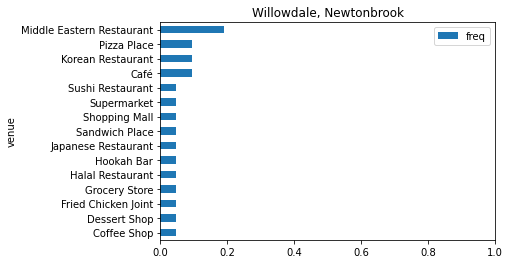

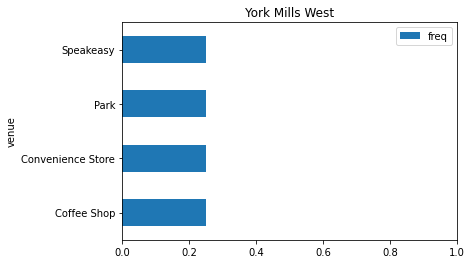

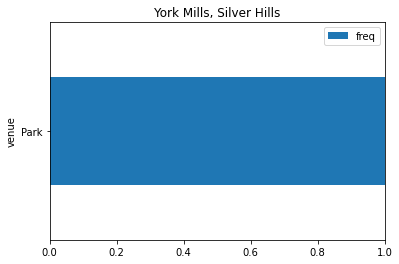

In [117]:
for hood in north_york_grouped['Neighbourhood']:
    temp = north_york_grouped[north_york_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp[temp['freq'] > 0]
    temp.sort_values(by='freq').plot.barh(x='venue', y='freq', title=hood, xlim=(0,1))

#### 10 Most Common Venues in each Neighbourhood

In [119]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = north_york_grouped['Neighbourhood']

for ind in np.arange(north_york_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(north_york_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Home Service,American Restaurant,Men's Store,Platform,Pizza Place,Pharmacy,Pet Store,Park,Nightclub,Movie Theater
1,Bayview Village,Trail,Construction & Landscaping,Park,American Restaurant,Men's Store,Platform,Pizza Place,Pharmacy,Pet Store,Nightclub
2,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Indian Restaurant,Hobby Shop,Fast Food Restaurant,Pub,Juice Bar,Restaurant,Comfort Food Restaurant
3,Don Mills,Intersection,Coffee Shop,Gas Station,Grocery Store,Spa,Gym,Burger Joint,Bubble Tea Shop,Supermarket,Soccer Field
4,Downsview,Pizza Place,Discount Store,Vietnamese Restaurant,Coffee Shop,Turkish Restaurant,Fast Food Restaurant,Sandwich Place,Shopping Mall,Beer Store,Grocery Store


#### Cluster Neighbourhood with k-Means

Find suitable number of clusters

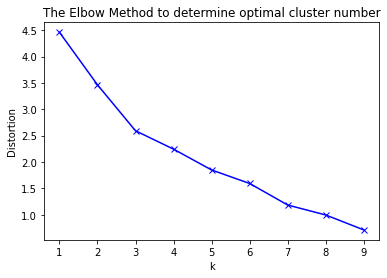

In [131]:
north_york_grouped_clustering = north_york_grouped.drop('Neighbourhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(north_york_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method to determine optimal cluster number')
plt.show()

Optial number of clusters is 4.

In [132]:
k=4
kmeans = KMeans(n_clusters=k)
kmeans.fit(north_york_grouped_clustering)
kmeans.labels_[0:10] 

array([2, 1, 1, 1, 1, 1, 1, 0, 1, 0])

In [134]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
north_york_merged = df_districts[df_districts['Borough'] == 'North York'].reset_index(drop=True)
north_york_merged = north_york_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
north_york_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,0,Fast Food Restaurant,Food & Drink Shop,Park,American Restaurant,Pub,Platform,Pizza Place,Pharmacy,Pet Store,Nightclub
1,M4A,North York,Victoria Village,43.73057,-79.31306,1,Pharmacy,Park,Grocery Store,American Restaurant,Men's Store,Platform,Pizza Place,Pet Store,Nightclub,Movie Theater
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,1,Clothing Store,Women's Store,Restaurant,Cosmetics Shop,Furniture / Home Store,Men's Store,Bookstore,Food Court,Toy / Game Store,Rental Car Location
3,M3B,North York,Don Mills,43.74923,-79.36186,1,Intersection,Coffee Shop,Gas Station,Grocery Store,Spa,Gym,Burger Joint,Bubble Tea Shop,Supermarket,Soccer Field
4,M6B,North York,Glencairn,43.70687,-79.44812,1,Pizza Place,Grocery Store,Asian Restaurant,Italian Restaurant,Fast Food Restaurant,Bakery,Bank,Latin American Restaurant,Mediterranean Restaurant,Gas Station


#### Apply Cluster labels to North York neighbourhoods and plot data on map

In [148]:
# create map
location = geocoder.arcgis(f'Toronto, Ontario')
latitude = location.latlng[0]
longitude = location.latlng[1]

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(north_york_merged['Latitude'], north_york_merged['Longitude'], north_york_merged['Neighbourhood'], north_york_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![North York Clustering](north_york_clustering.png)